In [1]:
import geopandas as gpd
import pandas as pd
import rioxarray as rio
import numpy as np
from utils import *
import statsmodels.api as sm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing
from typing import Union

# Generate bottom-up estimates for non-living carbon stock changes

## 1. Introduction

## 2. Run Analysis

In [2]:
N_samples = 10_000

### 2.1. Soil erosion induced sink

We rely on two estimates - one based on [Van Oost et al. (2007)](https://www.science.org/doi/10.1126/science.1145724) and the other on [Wang et al. (2017)](https://www.nature.com/articles/nclimate3263). 

Van Oost et al., estimate a sink of 0.12 GtC yr<sup>-1</sup> with a 95% range of 0.06-0.27. We model this uncertainty as multiplicative (beause is more symetric around 0.12 in multiplicative terms) by usin a log-normal distribution with mean of 0.12 and std in log-space of 0.4.

In its SI, Wang et al. estimates 0.1±0.024 GtC yr<sup>-1</sup> sink from soil erosion.

In [3]:
# model the Van Oost data with a log-norma
s=0.4
van_oost_MC = np.random.lognormal(np.log(0.12)-(s**2)/2,s,N_samples)

# show that it reproduces the 95% confidence interval of the data 
print(f'Van Oost 95% confidence range from log-normal approximation: ({np.quantile(van_oost_MC,0.025):.2f},{np.quantile(van_oost_MC,0.975):.2f})')

wang_MC = np.random.normal(0.1,0.024,N_samples)
soil_erosion_MC = np.stack([van_oost_MC,wang_MC])[np.random.choice(np.arange(2),N_samples),range(N_samples)]

Van Oost 95% confidence range from log-normal approximation: (0.05,0.24)


In [4]:
print(f'soil erosion transport sink estimate (GtC/yr): {soil_erosion_MC.mean():.1f} ± {soil_erosion_MC.std():.1f}')

soil erosion transport sink estimate (GtC/yr): 0.1 ± 0.0


### 2.2. Soil Organic Carbon loss due to land-use changes

To estimate the soil organic carbon (SOC) losses induced by land-use changes, we rely on two main sources:

1. A recent study characterizing land-use emissions - [Houghton and Castanho (2023)](https://essd.copernicus.org/articles/15/2025/2023/)

2. A model of SOC estimating the effect of land use based on the study by [Sanderman et a. (2017)](https://www.pnas.org/doi/full/10.1073/pnas.1706103114).

For this estimate, we remove 30%±20% that, based on literature values, are contributed to estimates of SOC loss by soil erosion, which we treat seperately in the soil erosion induced sink section.

In [5]:
# Houghton and Castanho (2023) estimate soil
HC23 = pd.read_excel('../data/supplementary_analysis/nonliving_carbon/SOC_loss/houghton_castanho_2023/essd-15-2025-2023-t07.xlsx')
HC23 = HC23['Soil carbon (no peat)'].mean()

In [6]:
# data from Sandermann et al. 2017
# 2m
SOC2010_2m = rio.open_rasterio('../data/supplementary_analysis/nonliving_carbon/SOC_loss/sanderman_et_al_2017/SOCS_0_200cm_year_2010AD_10km.tif',masked=True)
SOC1990_2m = rio.open_rasterio('../data/supplementary_analysis/nonliving_carbon/SOC_loss/sanderman_et_al_2017/SOCS_0_200cm_year_1990AD_10km.tif',masked=True)

# 1m
SOC2010_1m = rio.open_rasterio('../data/supplementary_analysis/nonliving_carbon/SOC_loss/sanderman_et_al_2017/SOCS_0_100cm_year_2010AD_10km.tif',masked=True)
SOC1990_1m = rio.open_rasterio('../data/supplementary_analysis/nonliving_carbon/SOC_loss/sanderman_et_al_2017/SOCS_0_100cm_year_1990AD_10km.tif',masked=True)

# calculate the loss rate and conver to GtC/yr
sandermann_2m = (100*(SOC1990_2m-SOC2010_2m)*calc_area(SOC2010_2m)).sum()/1e15/(2010-1990)
sandermann_1m = (100*(SOC1990_1m-SOC2010_1m)*calc_area(SOC2010_1m)).sum()/1e15/(2010-1990)

In [7]:
SOC_loss_estimates = np.array([HC23,sandermann_2m,sandermann_1m])
# add fraction of SOC loss that is infact erosion
frac_erosion = np.random.normal(0.3,0.2,N_samples)
SOC_loss_MC = np.random.choice(SOC_loss_estimates,N_samples)*(1-frac_erosion)
print(f'SOC loss estimates (GtC/yr): {SOC_loss_MC.mean():.1f} ± {SOC_loss_MC.std():.2f}')

SOC loss estimates (GtC/yr): 0.2 ± 0.06


### 2.3. Peat carbon loss due to land-use change

For estimating the carbon loss in peatlands, we rely on values from the literature concentrated in the `peatlands.xlsx` file

In [8]:
# load estimates from the literature
orgnic_soils = pd.read_excel('../data/supplementary_analysis/nonliving_carbon/peat_loss/peatlands.xlsx',index_col=0)

# for each data source, sample from the estimate and the corresponsing uncertainty 1000 times
organic_soils_MC = np.stack([np.random.normal(x.loc['estimate'],np.nanmax([0,x.loc['std']]),N_samples) for _,x in orgnic_soils.iterrows()])

# choose one estimate from each sample to generate an MC sample
organic_soils_MC = organic_soils_MC[np.random.choice(np.arange(orgnic_soils.shape[0]),N_samples),range(N_samples)]

print(f'peatland carbon loss estimates (GtC/yr): {organic_soils_MC.mean():.1f} ± {organic_soils_MC.std():.1f}')

peatland carbon loss estimates (GtC/yr): 0.3 ± 0.2


### 2.4. Harvested wood products

We rely on two source for estimating the carbon sink in harvested wood products:

1. [Johnston and Radeloff (2019)](https://www.pnas.org/doi/full/10.1073/pnas.1904231116)

2. [Zhang et al. (2020)](https://pubs.acs.org/doi/10.1021/acs.est.9b05721)

In [9]:
# load data
JR19 = pd.read_excel('../data/supplementary_analysis/nonliving_carbon/HWP/pnas.1904231116.sd01.xlsm',sheet_name='Figures',skiprows=58,index_col=0)
JR19 =JR19.iloc[:1,:117].T

# take the mean across 1992-2015 and convert to GtC/yr
JR19 = JR19.loc[1992:2015].mean().values[0]/3.67/1e3


zhang20 = (2938-188)/1e3/(2015-1992) # table 2

HWP_MC = np.random.choice([JR19,zhang20],N_samples)
print(f'Harvested wood products estimate (GtC/yr): {HWP_MC.mean():.12f} ± {HWP_MC.std():.2f}')

Harvested wood products estimate (GtC/yr): 0.091857363092 ± 0.03


### 2.5. Landfills

We use the IPCC methane emission model from landfills that can be found in this [link](https://www.ipcc-nggip.iges.or.jp/public/2019rf/vol5.html). 

The model is based on Equation 3.2. in [Chapter 3](https://www.ipcc-nggip.iges.or.jp/public/2019rf/pdf/5_Volume5/19R_V5_3_Ch03_SWDS.pdf). The equation models the annual mass of decoposable organic carbon in landfills:

$$DDOC_m = W \times DOC \times DOC_f \times MCF$$

Where $DDOC_m$ is the mass of decomposable organic carbon, $W$ is the mass of solid waste that is put into landfills, $DOC$ is the organic carbon content in the waste (gC per g waste), $DOC_f$ is the fraction of organic carbon that decomposes under anaerobic conditions, and $MCF$ is part of the waste that will decompose under aerobic conditions (prior to the conditions becoming anaerobic).

There are two main pathways in which carbon can accumulate in landfills - carbon that is not decomposable ($1-DOC_f$) and decoposable carbon that has not been decomposed yet.

We estimate the fist component using the equation:

$$iDDOC_m = W \times DOC \times (1-DOC_f) \times MCF$$

For the second component, we use equation 3.4. in the model:

$$DDOC_{ma_T} = DDOC_{md_T} + (DDOC_{ma_{T-1}}*e^{-k})$$

Where T is the inventory year, DDOC<sub>ma<sub>T</sub></sub> is the decomposable carbon accumulated at year T, DDOC<sub>ma<sub>T-1</sub></sub> is the decomposable carbon accumulated at the pervious year, DDOC<sub>md<sub>T</sub></sub> is the decomposable carbon added this year, and k is the decay rate per year of decomposable carbon.

Overall, we need to know the following parameters. Each parameter (except MCF) is estimated per category of waste () and per country. W is estimated also for each year, and MCF is estimated only per country:

- W: waste inputs per year in units of mass

- DOC: the carbon content

- DOC<sub>f</sub>: the fraction of carbon that decomposes anaerobically

- MCF: fration of carbon that decomposes anaerobically

- k: the decay rate for decomposable carbon

Below, we specify the sources of data for estimating each parameter, specify the model functions, and run the model

#### 2.5.1. W - waste inputs

We estimate global waste inputs from the [World Bank report](https://openknowledge.worldbank.org/entities/publication/d3f9d45e-115f-559b-b14f-28552410e90a) on waste.

In [10]:
world_bank_data = pd.read_csv('../data/supplementary_analysis/nonliving_carbon/landfills/country_level_data.csv').set_index('iso3c')

# calculate the total MSW generated in the world per capita in g per capita per year 
total_msw_per_capita = world_bank_data['total_msw_total_msw_generated_tons_year']/world_bank_data['population_population_number_of_people'] * 1e6

To scale the waste production in time, we use data on the total population on Earth in each country

In [11]:
# from https://datacatalog.worldbank.org/search/dataset/0037655/Population-Estimates-and-Projections
population = pd.read_csv('../data/supplementary_analysis/nonliving_carbon/landfills/Population-EstimatesCSV.csv').iloc[:,:-1]
population = population[population['Indicator Name'] == 'Population, total']
population.set_index('Country Code', inplace=True)
population = population.iloc[:,3:]
population.columns = population.columns.astype(int)

# create a dataframe with the population data
pop_df = population.iloc[:,:2020]
pop_df.index.name = 'iso3c'
pop_df.columns.name = 'year'


We also define the waste composition in four different categories: paper, food, wood, and yard. The remaining parameters will be estimated for each one of those categories.

In [12]:
# take the composition fraction of waste from the world bank data
composition = world_bank_data[['composition_paper_cardboard_percent','composition_food_organic_waste_percent','composition_wood_percent','composition_yard_garden_green_waste_percent']]/100
meterials = ['paper','food','wood','yard']
composition.columns = meterials
composition.columns.name = 'materials'


Calculate the total amount of waste per year per country per material (W)

In [13]:
W = pop_df.mul(total_msw_per_capita,axis=0).mul(composition.stack(),axis=0)

#### 2.5.2. DOC - fraction of organic carbon

Values are based on the default parameters of the IPCC Waste model

In [14]:
# from IPCC model - https://www.ipcc-nggip.iges.or.jp/public/2019rf/pdf/5_Volume5/19R_V5_Waste_Model.xlsx
DOC = pd.Series([0.4,0.15,0.43,0.2],index=meterials)
DOC_std = pd.DataFrame([[0.36,0.45],[0.08,0.2],[0.39,0.46],[0.18,0.22]],index=DOC.index,columns=['low','high']).mean(axis=1)/2
DOC.index.name = 'materials'

#### 2.5.3. DOC<sub>f</sub> - fraction of decomposable organic carbon in anaerobic conditions

Values are based on Table 3 in the [IPCC guidelines](https://www.ipcc-nggip.iges.or.jp/public/2019rf/pdf/5_Volume5/19R_V5_3_Ch03_SWDS.pdf)

In [15]:
fDOC = pd.Series([0.5,0.7,0.1,0.7],index=meterials)
fDOC.index.name = 'materials'

#### 2.5.4. MCF - the aerobic exposure of waste

We use data from Table S8 in [Earles et al. (2012)](doi.org/10.1038/NCLIMATE1535) based on the GDP of a country. We take GDP data from the world bank report.

In [16]:
# based on Table S8 in  10.1038/NCLIMATE1535
MCF = pd.cut(world_bank_data['gdp'],bins=[0,10_000,30_000,100_000_00],labels=[0.4,0.6,0.9]).astype(float)


#### 2.5.5. k - decay rates

Based in Table 3.3. in [IPCC guidelines](https://www.ipcc-nggip.iges.or.jp/public/2019rf/pdf/5_Volume5/19R_V5_3_Ch03_SWDS.pdf), we use mean values and ranges of decay rates for different countries based on Mean Annual Temperature (MAT), Aridity Index (AI = MAP/PET) and Mean Annual Percipitation (MAP).

We exctact MAP, MAT and AI data for each country based on [WorldClim](https://www.worldclim.org/data/worldclim21.html) data, and based on [Zomer et al. (2022)](https://www.nature.com/articles/s41597-022-01493-1).

In [17]:
# load country data
countries = gpd.read_file('../data/country_data/country_data_w_RECCAP_Pan_FAO.shp')

# load MAT, MAP and AI data
# from https://www.worldclim.org/data/worldclim21.html
MAT = rio.open_rasterio('../data/supplementary_analysis/nonliving_carbon/landfills/wc2.1_10m_bio_1.tif',mask_and_scale=True)[0,:,:]
MAP = rio.open_rasterio('../data/supplementary_analysis/nonliving_carbon/landfills/wc2.1_10m_bio_12.tif',mask_and_scale=True)[0,:,:]

# from https://www.nature.com/articles/s41597-022-01493-1
AI = rio.open_rasterio('../data/supplementary_analysis/nonliving_carbon/landfills/Global-AI_ET0_v3_annual/ai_v3_yr.tif',mask_and_scale=True)[0,:,:]
# according to the readme file in Global-AI_ET0_v3_annual/Global-AI_PET_v3 - Readme.pdf - need to scale by 0.0001
AI = AI.rio.reproject_match(MAT)/1e4 

# make a dataset with the country data, the MAT, MAP and AI data
cras = make_geocube(countries.reset_index().reset_index(),measurements=['index'],like=AI)['index']
MAT['countries'] = cras
MAP['countries'] = cras
AI['countries'] = cras

# calculate the mean MAT, MAP and AI for each country
country_mat = (MAT*calc_area(MAT)).groupby('countries').sum()/(MAT*calc_area(MAT)/MAT).groupby('countries').sum()
country_map = (MAP*calc_area(MAP)).groupby('countries').sum()/(MAP*calc_area(MAP)/MAP).groupby('countries').sum()
country_ai = (AI*calc_area(AI)).groupby('countries').sum()/(AI*calc_area(AI)/AI).groupby('countries').sum()

# concatenate the MAT, MAP and AI data into a single dataframe
dfs = [country_mat.drop_vars(['band','spatial_ref']).to_dataframe(name='MAT'),
country_map.drop_vars(['band','spatial_ref']).to_dataframe(name='MAP'),
country_ai.drop_vars(['band','spatial_ref']).to_dataframe(name='AI')]
country_climate = pd.concat(dfs,axis=1).join(countries.reset_index()['ISO_A3_EH'])

# determine the climate of each country based on the categories in Table 3.3. in https://www.ipcc-nggip.iges.or.jp/public/2019rf/pdf/5_Volume5/19R_V5_3_Ch03_SWDS.pdf
def determine_climate(x):
    if x['MAT']>20:
        return 'dry tropical' if x['MAP']<1000 else 'wet tropical'
    else:
        return 'dry temperate' if x['AI']<1 else 'wet temperate'

# apply the function to the dataframe
country_climate['climate'] = country_climate.apply(determine_climate,axis=1)

# rename the country ISO code column
country_climate.rename(columns={'ISO_A3_EH':'iso3c'},inplace=True)

In [18]:
# based on  Table 3.3 in https://www.ipcc-nggip.iges.or.jp/public/2019rf/pdf/5_Volume5/19R_V5_3_Ch03_SWDS.pdf
ks = pd.DataFrame({'paper':[0.04,0.06,0.045,0.07],'food':[0.06,0.185,0.085,0.4],'wood':[0.02,0.03,0.025,0.035],'yard':[0.05,0.1,0.065,0.17]},index=['dry temperate','wet temperate','dry tropical','wet tropical'])
ks_low = pd.DataFrame({'paper':[0.03,0.05,0.04,0.06],'food':[0.05,0.1,0.07,0.17],'wood':[0.01,0.02,0.02,0.03],'yard':[0.04,0.06,0.05,0.15]},index=['dry temperate','wet temperate','dry tropical','wet tropical'])
ks_high = pd.DataFrame({'paper':[0.05,0.07,0.06,0.085],'food':[0.08,0.2,0.1,0.7],'wood':[0.03,0.04,0.04,0.05],'yard':[0.06,0.1,0.08,0.2]},index=['dry temperate','wet temperate','dry tropical','wet tropical'])

# add the index and column names
ks.index.name = 'climate'
ks.columns.name = 'meterials'
ks_low.index.name = 'climate'
ks_low.columns.name = 'meterials'
ks_high.index.name = 'climate'
ks_high.columns.name = 'meterials'

#### 2.5.6. The model

In [19]:
def landfill_model(W:pd.DataFrame, DOC:pd.DataFrame, DOCf:pd.DataFrame,MCF:pd.DataFrame,ks:pd.DataFrame,return_CH4=False) -> Union[tuple,pd.DataFrame]:
    """
    The IPCC landfill model for calculating carbon dynamics in landfills


    Parameters:
    W (pd.DataFrame): the waste data (in g per year per country per material)
    DOC (pd.DataFrame): the carbon content (per material)
    DOCf (pd.DataFrame): the fraction of carbon that decomposes anaerobically (per material)
    MCF (pd.DataFrame): fration of carbon that decomposes anaerobically (per country)
    ks (pd.DataFrame): the decay rate for decomposable carbon (per material and climate)
    return_CH4 (bool): if True, return the CH4 emissions

    Returns:
    tuple: the sink of iDDOC and DDOC_ma
    pd.DataFrame: the CH4 emissions
    """

    # Eq. 3.2 in https://www.ipcc-nggip.iges.or.jp/public/2019rf/pdf/5_Volume5/19R_V5_3_Ch03_SWDS.pdf
    # unaerobic_C_input = W * DOC * MCF
    unaerobic_C_input = W.unstack('iso3c')\
                        .mul(DOC,axis=0).stack(future_stack=True).unstack('materials')\
                        .mul(MCF,axis=0).stack(future_stack=True)#.unstack('iso3c')
    
    # the decomposable fraction is the fraction of the unaerobic_C_input that decomposes anaerobically: unaerobic_C_input * fDOC
    DDOC = unaerobic_C_input.mul(fDOC,axis=0)

    # the idecomposable fraction is the fraction of the unaerobic_C_input that does not decompose anaerobically: unaerobic_C_input * (1-fDOC)
    iDDOC = unaerobic_C_input.mul(1-fDOC,axis=0)

    # initialize the DDOC_ma and DDOC_md dataframes                            
    DDOC_ma = DDOC.copy()
    DDOC_md = DDOC.copy()
    DDOC_md.iloc[:,0] = 0
    
    # for each year, calculate the DDOC_ma and DDOC_md following equation 3.4.
    # DDOC_{ma_T} = DDOC_{md_T} + (DDOC_{ma_T-1}*e^{-k})
    # for each year
    for c in range(1,DDOC.shape[1]):
        
        # calculate the organic matter remaining from last year
        prev_year = DDOC_ma.iloc[:,c-1].unstack().mul(np.exp(-ks.unstack()),axis=0).stack()
        
        # determine the carbon that accumulates in the landfill
        DDOC_ma.iloc[:,c] += prev_year.reindex(DDOC_ma.iloc[:,c].index)

        # determine the carbon that decomposes in the landfill
        DDOC_md.iloc[:,c] = DDOC_ma.iloc[:,c-1] - prev_year.reindex(DDOC_ma.iloc[:,c].index)

    # set the column names to integers 
    iDDOC.columns = iDDOC.columns.astype(int)
    DDOC_ma.columns = iDDOC.columns.astype(int)
    DDOC_md.columns = iDDOC.columns.astype(int)

    # calculate the average sink of iDDOC and DDOC_ma
    iDDOC_sink = iDDOC.sum().loc[1993:2019].mean()/1e15 #tons C to GtC
    DDOC_ma_sink = DDOC_ma.sum().diff().loc[1993:2019].mean()/1e15 #tons C to GtC
    
    # for methane emissions, calculate the CH4 emissions based on equation 3.3.
    F = 0.5
    C_to_CH4 = 16/12
    DDOC_md = DDOC_md.sum()*F*C_to_CH4/1e12

    # return the CH4 emissions if requested
    if return_CH4:
        return DDOC_md
    
    # return the sink of iDDOC and DDOC_ma
    else:
        return iDDOC_sink,DDOC_ma_sink

#### 2.5.7. Run the model

First we sample random combinations of the DOC and k parameters from their ranges to get an uncertainty estimate

In [20]:
# sample DOC parameters
DOC_MC = np.stack([np.random.normal(m,s,N_samples) for m,s in zip(DOC,DOC_std)]).T

# sample k paramters
res = []
for low,high in zip(ks_low.stack().values,ks_high.stack().values):
    res.append(np.random.uniform(low,high,N_samples))
ks_MC = np.array(res).T.reshape(-1,4,4)


Then, we run the model with these parameter samples

In [21]:
def run_model(DOC_s:np.array,ks_s:np.array) -> tuple:
    """
    Run the landfill model with the given DOC and ks values

    Parameters:
    DOC_s (np.array): the DOC values
    ks_s (np.array): the ks values

    Returns:
    tuple: the sink of iDDOC and DDOC_ma
    """

    # create the input dataframes for DOC and ks
    DOC_input = pd.Series(DOC_s,index=DOC.index)
    ks_input = ks.copy()
    ks_input[:] = ks_s
    
    # calculate teh relavant decay rates per coutnry per material
    ks_per_country = country_climate[['iso3c','climate']].merge(ks_input.stack().reset_index(),on='climate').set_index(['iso3c','meterials'])[0]
    
    # run the model
    iDDOC_sink,DDOC_ma_sink = landfill_model(W,DOC_input,fDOC,MCF,ks_per_country)
    return iDDOC_sink,DDOC_ma_sink


# run the model in parallel
num_cores = multiprocessing.cpu_count()
res = Parallel(n_jobs=num_cores)(delayed(run_model)(a,b) for a,b in zip(DOC_MC,ks_MC))

# aggregate the results from the parallel runs
landfill_MC = np.array(res).sum(axis=1)
print(f'landfilll estimate (GtC/yr): {landfill_MC.mean():.1f} ± {landfill_MC.std():.2f}')

landfilll estimate (GtC/yr): 0.1 ± 0.03


#### 2.5.8. Validate the model

We run the model to estimate methane emissions and compare them against numbers from the literature from the IPCC AR4 report:
https://archive.ipcc.ch/publications_and_data/ar4/wg1/en/ch7s7-4-1.html

and from the Global Methane Budget report:
https://essd.copernicus.org/articles/12/1561/2020/

In [22]:
def run_model_CH4(DOC_s:np.array,ks_s:np.array) -> tuple:
    """
    Run the landfill model with the given DOC and ks values

    Parameters:
    DOC_s (np.array): the DOC values
    ks_s (np.array): the ks values

    Returns:
    tuple: the sink of iDDOC and DDOC_ma
    """

    # create the input dataframes for DOC and ks
    DOC_input = pd.Series(DOC_s,index=DOC.index)
    ks_input = ks.copy()
    ks_input[:] = ks_s
    
    # calculate teh relavant decay rates per coutnry per material
    ks_per_country = country_climate[['iso3c','climate']].merge(ks_input.stack().reset_index(),on='climate').set_index(['iso3c','meterials'])[0]
    
    # run the model
    return landfill_model(W,DOC_input,fDOC,MCF,ks_per_country,True)

num_cores = multiprocessing.cpu_count()
res = Parallel(n_jobs=num_cores)(delayed(run_model_CH4)(a,b) for a,b in zip(DOC_MC,ks_MC))

# aggregate the results from the parallel runs
CH4_MC = pd.concat(res,axis=1)

Plot the comparison

[Text(0, 0.5, 'MtCH4/yr'), Text(0.5, 0, 'year')]

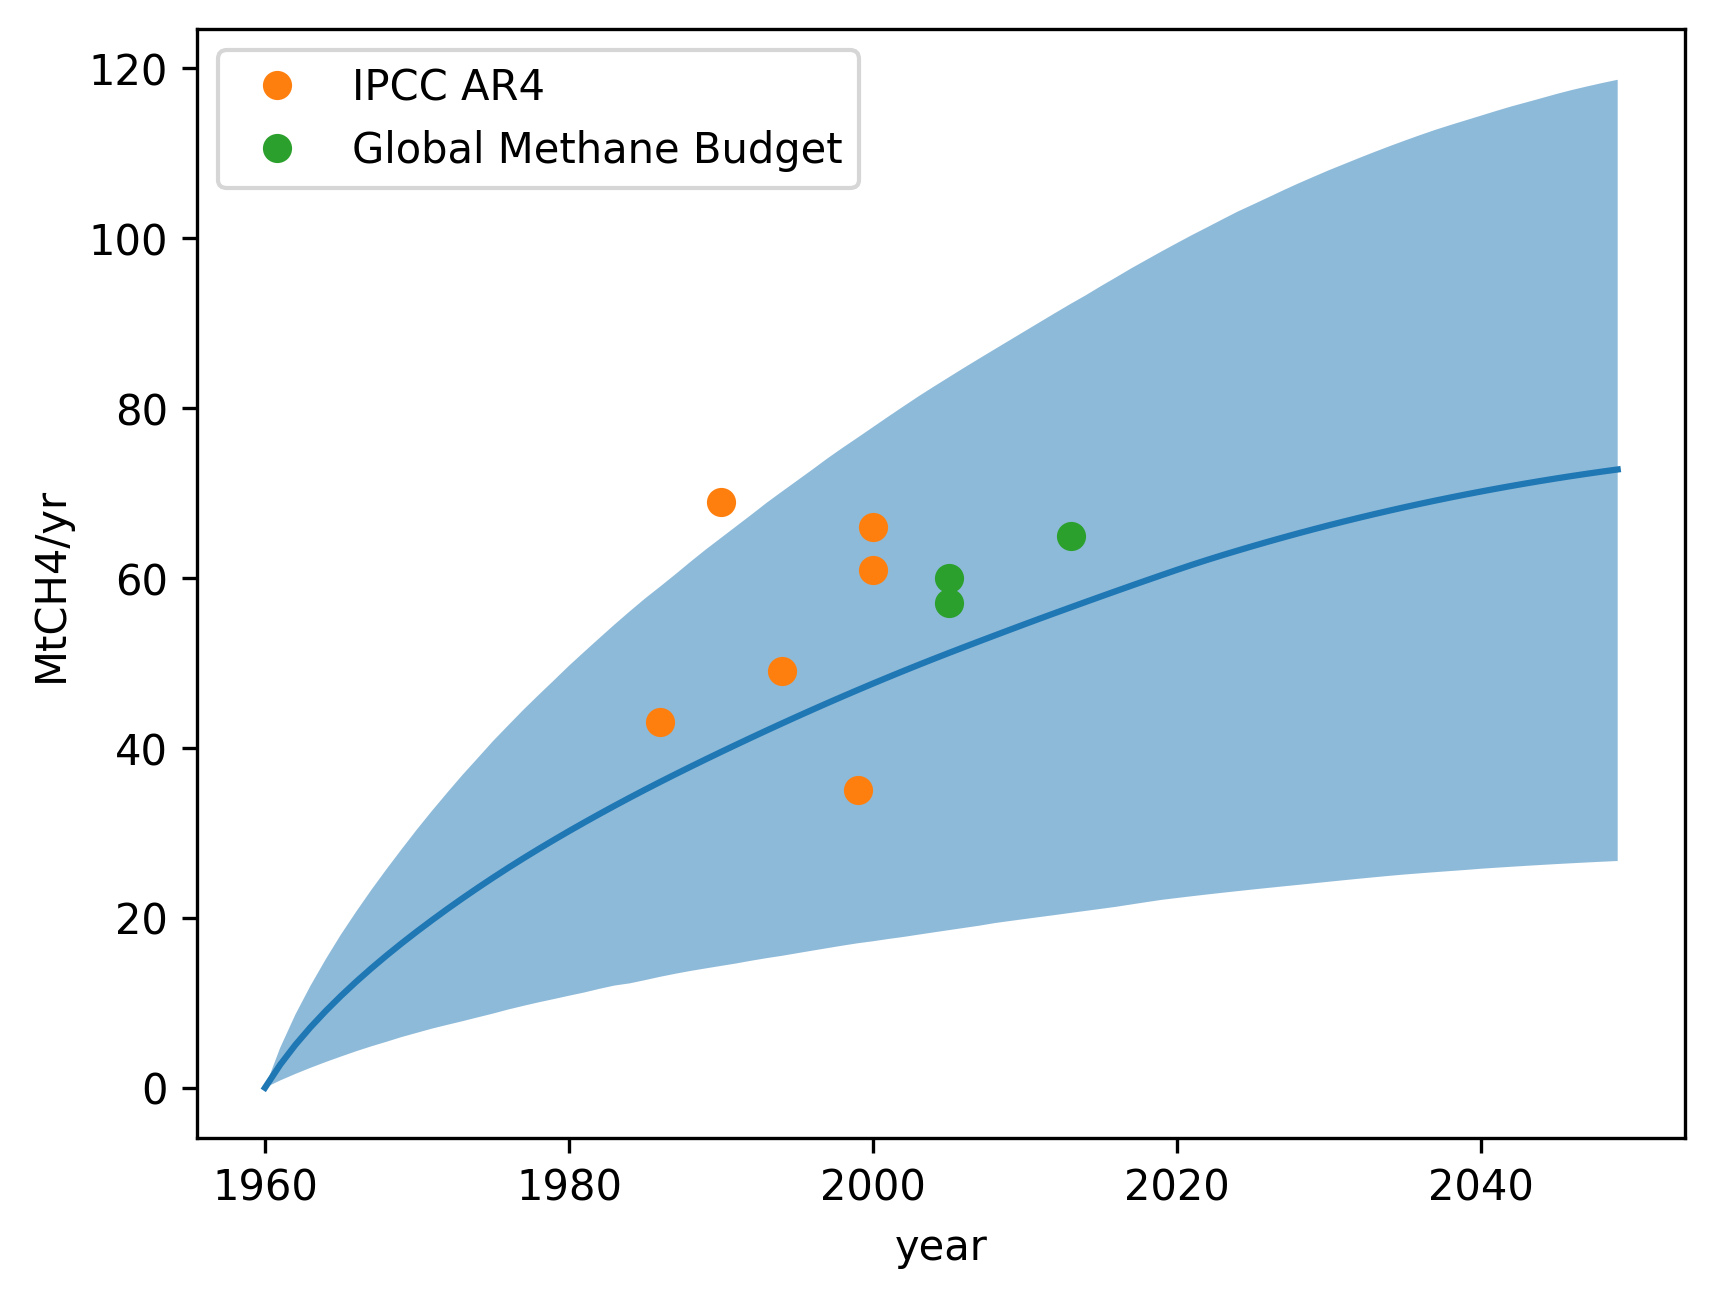

In [23]:
# load the literature data
AR4_data = pd.DataFrame({'year':[1986,2000,2000,1990,1994,1999,],'MtC/yr':[43,66,61,69,49,35]})
GMB = pd.DataFrame({'year':[2005,2005,2013],'MtC/yr':[57,60,65]})

# set up the figure
fig,ax = plt.subplots(dpi=300)

# plot the model results
CH4_MC.mean(axis=1).plot(ax=ax,label='model')
ax.fill_between(CH4_MC.index,CH4_MC.quantile(0.025,axis=1),CH4_MC.quantile(0.975,axis=1),alpha=0.5)

# plot the literature data
AR4_data.plot(x='year',y='MtC/yr',ax=ax,marker='o',label='IPCC AR4',lw=0)
GMB.plot(x='year',y='MtC/yr',ax=ax,marker='o',label='Global Methane Budget',lw=0)

# set the axes labels
ax.set(ylabel='MtCH4/yr',xlabel='year')

### 2.6. Artificial reservoirs

For estimating the carbon burial sink in artificial reservoirs, we rely on two data sources:

1. [Mendonça et al. (2017)](https://www.nature.com/articles/s41467-017-01789-6)

2. [Maavara et al. (2017)](https://www.nature.com/articles/ncomms15347)

We modify the estimates in both studies to be more consistent with other pieces of information about artificial reservoirs.

#### Mendonça et al.

The study relies on upscaling local measurements of carbon burial in lakes and reservoirs. For the upscaling, they use two different products that report the global surface area of artificial reservoirs - the [GLOWABO](https://doi.org/10.1002%2F2014GL060641) dataset and an inventory based on [Raymond et al. (2013)](https://doi.org/10.1038%2Fnature12760). In our analysis, we use only the estimates based on GLOWABO because the estimate for the global surface area from Raymond et al. (261,243 in Table 1 in Mendonça et al.) is much smaller than an independent estimate from the Global Reservoir and Dam Database v1.3. Below, we provide an estimate for the global surface area of reservoirs from GRanD v1.3

In [24]:
# load data
GRanD = gpd.read_file('../data/supplementary_analysis/nonliving_carbon/reservoirs/GRanD_Version_1_3/GRanD_dams_v1_3.shp')

# calculate the area of the reservoirs in km2
print(f'{GRanD.AREA_SKM.sum():.0f} km2 of reservoirs')

472871 km2 of reservoirs


Therefore, we use the estimate based on GLOWABO in Table 1 in Mendonça et al.

In [25]:
mendonca = np.array([0.07,0.11])

#### Maavara et al.

We modify the estimate by Maavara et al. in two ways to make it more representative.

First, we modify the estimate to make it more consistent with estimates of sediment trapping in inland waters. The current estimate implies a ratio between POC inputs into watersheds and output into the oceans.

In [27]:
# load data from Table S6 in Maavara et al. 2017
maavara_data = pd.read_excel('../data/supplementary_analysis/nonliving_carbon/reservoirs/maavara_et_al_2017_table_s6.xlsx',index_col=0)
maavara_data = maavara_data.iloc[:,1:10]


# ratio between POC load to watersheds and POC export to coasts
POC_input_output_ratio = (maavara_data.loc['POC export to coast']/maavara_data.loc['POC load to watersheds']).mean()
print(f'the ratio between POC input and export is ≈{POC_input_output_ratio.mean():.2f}')


the ratio between POC input and export is ≈0.75


This fraction is larger than our current understanding of sediment transport (that contains in it POC), that implies that sediment output into the ocean decreased by 2-fold due to damming while inputs have increased by 2-fold due to land-use. 

We scale the POC input into reservoirs by a factor of 2 to increase POC trapping in inland waters, and test the impact of such a scenario on the ratio betweem POC outputs to coasts and input to watersheds. To estimate the impact, we rely on the ratio between inputs of POC into reservoirs and the POC loss between its inputs into watersheds and its export into coasts:

In [28]:

# estimate the ratio between the POC lost during transport to coasts and the POC load to the reservoirs
POC_reservoir_input_output = (maavara_data.loc['POC load to watersheds'] - maavara_data.loc['POC export to coast'])/maavara_data.loc['POC load to reservoirs'] 
print(f'the ratio between POC lost during transport to coasts and the POC load to the reservoirs is ≈{POC_reservoir_input_output.mean():.2f}±{POC_reservoir_input_output.std():.2f}')


the ratio between POC lost during transport to coasts and the POC load to the reservoirs is ≈0.72±0.04


We use this ratio and estimate that if we increase the inputs into reservoirs by 2-fold the new ratio between POC inputs into watersheds and outputs into coasts will be:

In [29]:
POC_fold_increase = 2

# calculate new POC loss if we increase the POC load to the reservoirs by a factor of 2
new_POC_loss = maavara_data.loc['POC load to reservoirs'] *POC_fold_increase *POC_reservoir_input_output

# calculate new POC export to oceans 
new_POC_export = maavara_data.loc['POC load to watersheds'] - new_POC_loss

# calculate the new ratio between POC load to watersheds and POC export to coasts
newPOC_input_output_ratio = (new_POC_export/maavara_data.loc['POC load to watersheds'])
print(f'the ratio between POC input and export is ≈{newPOC_input_output_ratio.mean():.2f}±{newPOC_input_output_ratio.std():.2f}')


the ratio between POC input and export is ≈0.50±0.08


This ratio is more consistent with the literature. 

Increasing the inputs into reservoirs will also impact POC burial in reservoirs. In the data in Maavara et al. there is a consistent ratio between POC inputs into reservoirs and the POC burial in reservoirs

In [30]:
# ratio between POC burial and POC input into reservoirs
POC_bur_frac = maavara_data.loc['POCbur,tot'].astype(float)/maavara_data.loc['POC load to reservoirs'].astype(float)
print(f'the mean POC burial as a fraction of inputs is {POC_bur_frac.mean():.1f}±{POC_bur_frac.std():.2f}')


the mean POC burial as a fraction of inputs is 0.8±0.05


We use this fraction and the new POC inputs into reservoirs to calculate the new POC burial in reservoirs:

In [31]:
# Using this doubling of reservoir loads and the ratio between POC load adn burial, we can estimate the POC burial in the new scenario
new_maavara_POC_burial = maavara_data.loc['POC load to reservoirs'].astype(float)*POC_bur_frac.mean()*POC_fold_increase

# We take the estimates from 2000 and 2030 to be the representative values

new_maavara_POC_burial = (new_maavara_POC_burial[new_maavara_POC_burial.index.str.contains('2000')] +new_maavara_POC_burial[new_maavara_POC_burial.index.str.contains('2030')].mean())/2

# convert the units of Tmol yr-1 to GtC yr-1
new_maavara_POC_burial = new_maavara_POC_burial.values[0]*12/1e3

print(f'The new estimate for POC burial in reservoirs is ≈{new_maavara_POC_burial:.2f} GtC/yr')

The new estimate for POC burial in reservoirs is ≈0.07 GtC/yr


Second, the Maavara et al. estimate doesn't include small impoundments. To estimate the magnitude of the burial in these small impoundments, we rely on local carbon burial estimates from different reservoirs and lakes from Mendonça et al., and fit a linear model of the log of the carbon burial rate and the surface area of the water body, as done in Mendonça et al.

In [32]:
# load the data from Mendonça et al.
mendonca_data = pd.read_excel('../data/supplementary_analysis/nonliving_carbon/reservoirs/41467_2017_1789_MOESM4_ESM.xlsx')

# take only data from reservoirs in Mendonça et al.
resv = mendonca_data[mendonca_data['System_type']=='Reservoir']

# convert the surface area and carbon burial data to log-space to do a linear regression
fit_data = np.log10(resv[['lake_area','OCb_whole-system']]).dropna()

# construct a linear model
model = sm.OLS(fit_data['OCb_whole-system'],sm.add_constant(fit_data['lake_area'])).fit()

# sample from the model to get samples of the parameters of the model to scale surface area to 
model_MC = np.random.multivariate_normal(model.params,model.cov_params(),N_samples)

[Text(0.5, 0, 'log(lake area)'), Text(0, 0.5, 'log(OC burial per unit area)')]

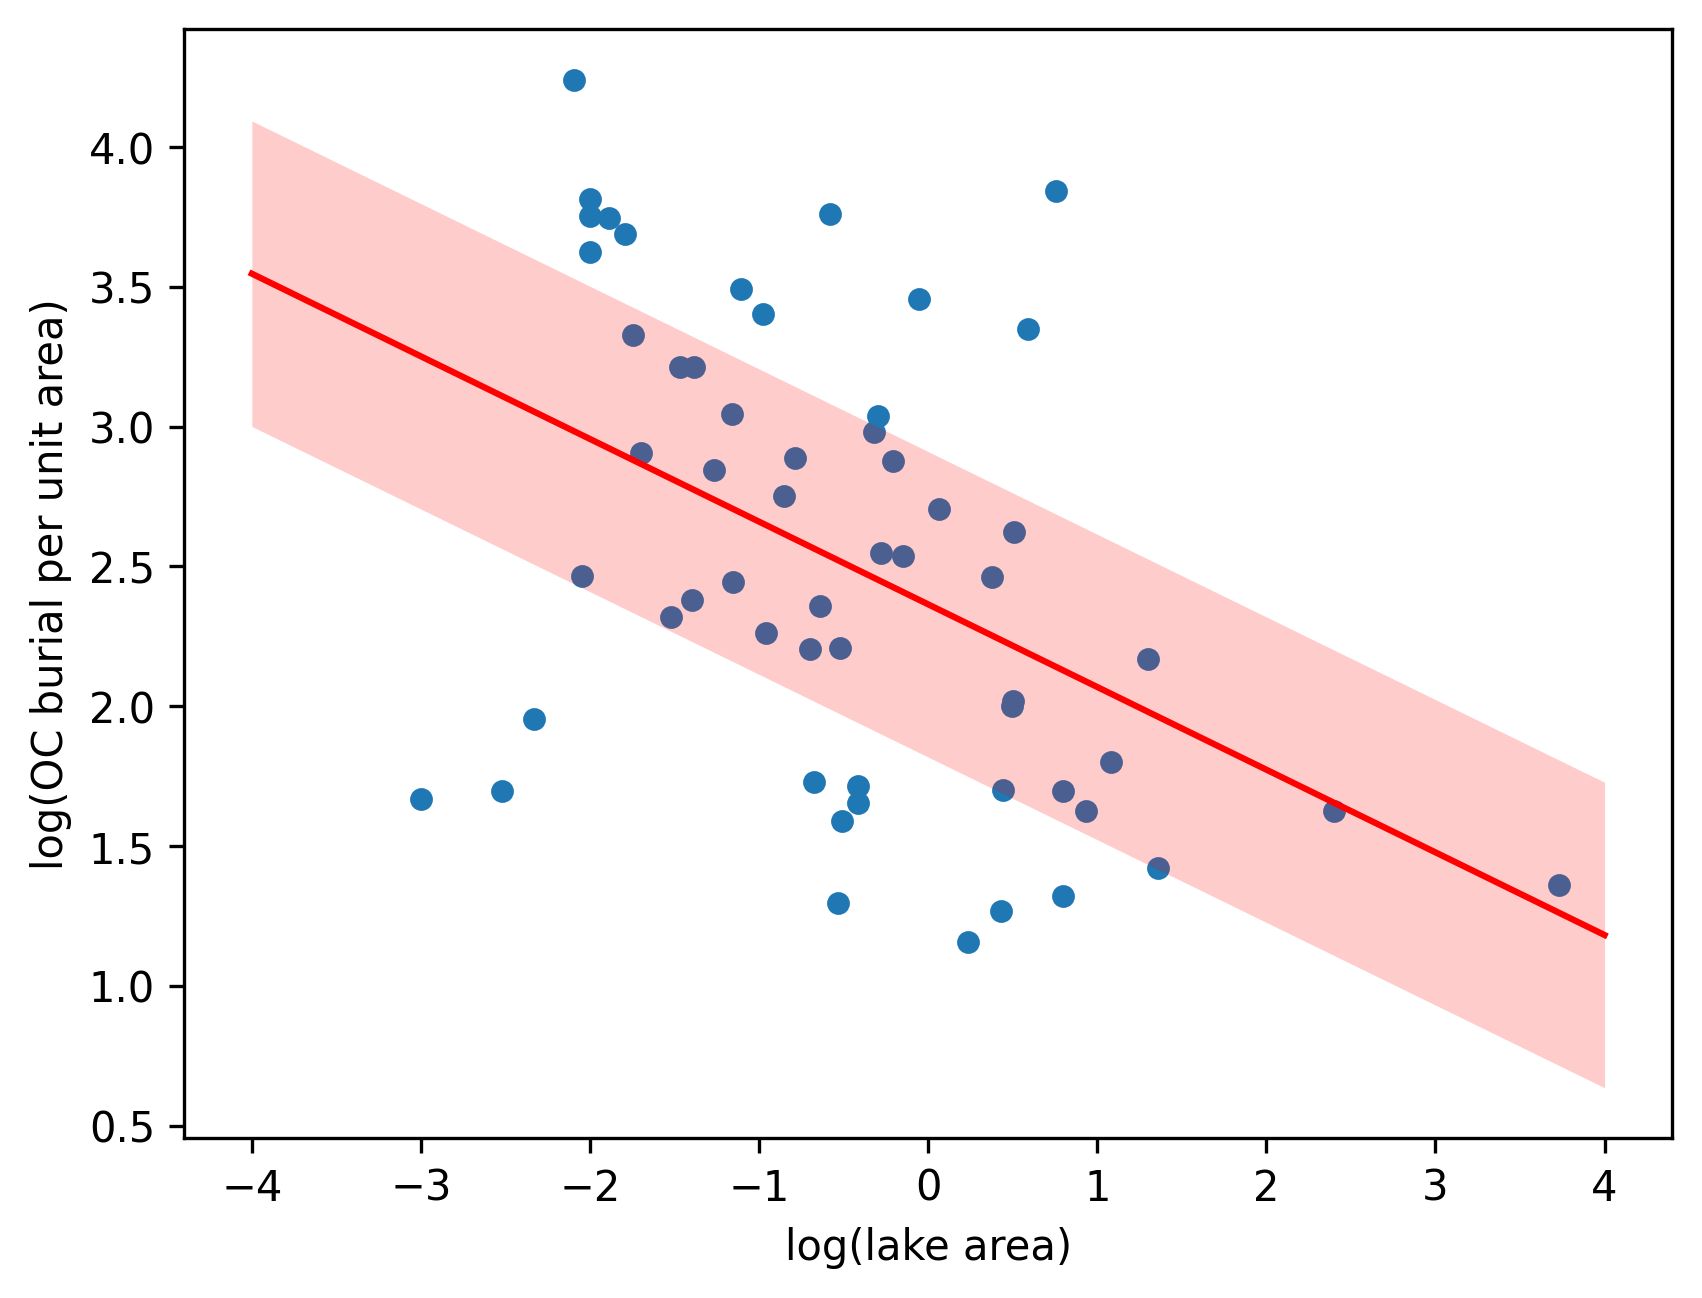

In [33]:
fig, ax = plt.subplots(dpi=300)
fit_data.plot.scatter('lake_area', 'OCb_whole-system',ax=ax)
xrange = np.linspace(-4,4,100)
model_pred = xrange*model.params['lake_area']+model.params['const']
ax.plot(xrange,model_pred,color='red')
ax.fill_between(xrange,model_pred+model.mse_resid,model_pred-model.mse_resid,color='red',alpha=0.2,lw=0)

ax.set(xlabel='log(lake area)',ylabel='log(OC burial per unit area)')

We use this model to convert estimates of the total surface area of small impoundments from Table 1 in [Lehner et al. 2011](https://esajournals.onlinelibrary.wiley.com/doi/abs/10.1890/100125) to estimates of carbon burial.

In [34]:
# load data from Table 1 of Lehner et al. 2011
lehner_data = pd.read_excel('../data/supplementary_analysis/nonliving_carbon/reservoirs/reservoir_data.xlsx',sheet_name='Lehner 2011')
lehner_data.drop(index=0,inplace=True)

# take only reservoirs with area < 10 km2
lehner_data = lehner_data[:5]
res = []
# for each sample, calculate the carbon burial in small ponds using the model parameters and the surface area from Lehner et al.
for i in range(N_samples):
    # calculate the carbon burial per unit area in small ponds
    OCb_lehner = np.log10(lehner_data['Avg area (km2).1'])*model_MC[i,1]+model_MC[i,0]

    # add to the prediction the MSE resiudal of the model
    OCb_lehner = OCb_lehner + np.random.normal(0,model.mse_resid)

    # convert back to linear space
    OCb_lehner = 10**(OCb_lehner)

    
    # multiply by the characteristic area and number of small ponds
    OCb_lehner = pd.concat([OCb_lehner,lehner_data[['Avg area (km2).1','Number.1']]],axis=1)

    # convert to GtC/yr from area in km2 and burial in gC/m2/yr
    res.append((OCb_lehner.prod(axis=1)*1e6).sum()/1e15)

# concatenate results from different samples
maavara_small_ponds = np.array(res)

In [35]:
# the final modified estimate for Maavara et al. is the sum of the small ponds data and the modified POC burial estimate
maavara_total = maavara_small_ponds + new_maavara_POC_burial

#### Final estimate

We combine the modified estimates from Mendonca et al. and from Maavara et al. to get to our final estimate

In [36]:
# set up an array with N_samples from from Mendonca and Maavara
reservoir_MC = np.zeros([N_samples,2])
reservoir_MC[:,0] = np.random.choice(mendonca,size=N_samples)
reservoir_MC[:,1] = maavara_total

# sample between those estimates to get a final estimate and uncertainty range
reservoir_MC = reservoir_MC[range(N_samples),np.random.choice(np.arange(2),N_samples)]

print(f'reservoir organic carbon burial estimate (GtC/yr): {reservoir_MC.mean():.2f} ± {reservoir_MC.std():.2f}')

reservoir organic carbon burial estimate (GtC/yr): 0.13 ± 0.13


### 2.7. Carbon burial in lakes

We rely on two sources for estimating the carbon burial in natural lakes:

1. [Mendonça et al. (2017)](https://www.nature.com/articles/s41467-017-01789-6)

2. [Anderson et al. (2020)](https://www.science.org/doi/10.1126/sciadv.aaw2145)

In [37]:
# take estimates from Table 1 of Mendonça et al.
mendonca_lake = np.array([0.18,0.1,0.05,0.04])

# take estimate from Anderson et al. and sample from its uncertainty
anderson_lake = np.random.normal(0.12,0.02,N_samples) # using half the 95% range in the paper
# set up an array with samples from the two sources
lake_MC = np.zeros([N_samples,2])
lake_MC[:,0] = np.random.choice(mendonca,size=N_samples)
lake_MC[:,1] = anderson_lake

# choose one estimate from each sample to generate an MC sample
lake_MC = lake_MC[range(N_samples),np.random.choice(np.arange(2),N_samples)]
print(f'lake organic carbon burial estimate (GtC/yr): {lake_MC.mean():.2f} ± {lake_MC.std():.2f}')

lake organic carbon burial estimate (GtC/yr): 0.11 ± 0.03


### 2.8. Carbon burial in wetlands

We consider coastal wetlands and pristine peatlands separately. For coastal wetland, we use the estimate from [Regnier et al. (2022)](https://www.nature.com/articles/s41586-021-04339-9).

In [38]:
# Data from Table S1 in Regnier et al.
regnier_MC = np.random.normal(0.11,0.05,N_samples)

print(f'organic carbon burial in coastal wetlands estimate (GtC/yr): {regnier_MC.mean():.2f} ± {regnier_MC.std():.2f}')

organic carbon burial in coastal wetlands estimate (GtC/yr): 0.11 ± 0.05


For pristine peatlands, we use estimates from several studies in the literature:

In [39]:
pristine_peatland_estimate = pd.read_excel('../data/supplementary_analysis/nonliving_carbon/wetlands/pristine_peatlands.xlsx',index_col=0)

# generate an estimate of the uncertainty from each source
pristine_peatland_MC = np.stack([np.random.normal(r['value'],np.nanmax([0,r['std']]),N_samples) for _,r in pristine_peatland_estimate.iterrows()],axis=1)
pristine_peatland_MC = pristine_peatland_MC[range(N_samples),np.random.choice(np.arange(pristine_peatland_estimate.shape[0]),N_samples)]
print(f'organic carbon burial in pristine peatlands estimate (GtC/yr): {pristine_peatland_MC.mean():.2f} ± {pristine_peatland_MC.std():.1f}')

organic carbon burial in pristine peatlands estimate (GtC/yr): 0.09 ± 0.1


The total wetland sink is the sum of coastal wetlands and pristine peatlands

In [40]:
wetlands_MC = pristine_peatland_MC+regnier_MC
print(f'organic carbon burial in wetlands estimate (GtC/yr): {wetlands_MC.mean():.2f} ± {wetlands_MC.std():.2f}')

organic carbon burial in wetlands estimate (GtC/yr): 0.20 ± 0.08


### 2.9. Overall estimate

In [41]:
total_estimate_MC = np.stack([-SOC_loss_MC,-organic_soils_MC,soil_erosion_MC,HWP_MC+landfill_MC,reservoir_MC,lake_MC,wetlands_MC]).sum(axis=0)
print(f'overall estimate for change in non-living organic carbon stocks (GtC/yr): {(total_estimate_MC).mean():.1f} ± {(total_estimate_MC).std():.1f}')

overall estimate for change in non-living organic carbon stocks (GtC/yr): 0.3 ± 0.3


### 2.10. Save results

In [42]:
results = pd.DataFrame([-SOC_loss_MC,-organic_soils_MC,soil_erosion_MC,HWP_MC+landfill_MC,reservoir_MC,lake_MC,wetlands_MC],index=['SOC loss','organic soils','soil erosion','HWP & landfill','reservoirs','inland waters','wetlands'])
results.loc['total estimate'] = results.sum(axis=0)
results = results.aggregate(['mean','std'],axis=1)
results.to_csv('../results/07_nonliving_OC/nonliving_OC_budget.csv')